In [34]:
%matplotlib inline

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split

from subprocess import check_output

In [35]:
RND_SEED=1

# Loading the data and feature engineering

In [36]:
samp = pd.read_csv('sample_submission.csv')
store =  pd.read_csv('store.csv')
test = pd.read_csv('test.csv')
train =  pd.read_csv('train.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
#Make joined datasets for test and train
train['Set'] = 1
test['Set'] = 0
df = pd.concat([train,test])

In [38]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [39]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [40]:
df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store
0,555.0,2015-07-31,5,NaN,1.0,1,5263.0,1,1,0,1
1,625.0,2015-07-31,5,NaN,1.0,1,6064.0,1,1,0,2
2,821.0,2015-07-31,5,NaN,1.0,1,8314.0,1,1,0,3
3,1498.0,2015-07-31,5,NaN,1.0,1,13995.0,1,1,0,4
4,559.0,2015-07-31,5,NaN,1.0,1,4822.0,1,1,0,5


In [41]:
#Fields have both "0" and 0 values
df["StateHoliday"].loc[df["StateHoliday"] == "0"] = 0

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
#Convert types StoreType, Assortment, StateHoliday
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes
df["StateHoliday"] = df["StateHoliday"].astype('category').cat.codes

In [43]:
df['StateHoliday'].value_counts()

0    1027067
1      20440
2       6690
3       4100
Name: StateHoliday, dtype: int64

In [44]:
#Let's find the average number of sales per shop and join it with store table
average_sales_customers = train.groupby('Store')[["Sales", "Customers"]].mean()
sales_customers_df = pd.DataFrame({'Store':average_sales_customers.index,
                      'Sales':average_sales_customers["Sales"], 'Customers': average_sales_customers["Customers"]}, 
                      columns=['Store', 'Sales', 'Customers'])
store = pd.merge(sales_customers_df, store, on='Store')

store.head()

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8021.769639,1100.057325,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,3867.110403,444.360934,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [45]:
#The table has null values
store.isnull().sum()

Store                          0
Sales                          0
Customers                      0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [46]:
#Remove shops that were opened but didn't sell anything
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [47]:
#Store id numbers of closed shops, later set them to null values
closed_ids = df["Id"][df["Open"] == 0].values

In [48]:
#Remove zero valued cells from closed_ids
closed_ids = closed_ids[~np.isnan(closed_ids)]

In [49]:
#Remove cells for closed shops from the table
df = df[df["Open"] != 0]

In [50]:
#Transform field CompetitionOpenSinceYear
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

store['CompetitionOpenInt'] = store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [51]:
#Define main features of the store table
features_store = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt']
features_y = ['Sales']

In [52]:
df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store
0,555.0,2015-07-31,5,NaN,1.0,1,5263.0,1,1,0,1
1,625.0,2015-07-31,5,NaN,1.0,1,6064.0,1,1,0,2
2,821.0,2015-07-31,5,NaN,1.0,1,8314.0,1,1,0,3
3,1498.0,2015-07-31,5,NaN,1.0,1,13995.0,1,1,0,4
4,559.0,2015-07-31,5,NaN,1.0,1,4822.0,1,1,0,5


In [53]:
df = pd.merge(df, store[features_store], how='left', on=['Store'])

In [54]:
#Define the main features correlating with the result
features_x = ['DayOfWeek','Promo', 'SchoolHoliday', 'StateHoliday', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt']

In [55]:
df[features_x].isnull().sum()

DayOfWeek                 0
Promo                     0
SchoolHoliday             0
StateHoliday              0
StoreType                 0
Assortment                0
CompetitionDistance    2262
CompetitionOpenInt        0
dtype: int64

In [56]:
#Put all Nan vauled cells in CompetitionDistance to -1
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(-1)

In [57]:
#Check again
df[features_x].isnull().sum()

DayOfWeek              0
Promo                  0
SchoolHoliday          0
StateHoliday           0
StoreType              0
Assortment             0
CompetitionDistance    0
CompetitionOpenInt     0
dtype: int64

In [58]:
df[features_x].head()

,DayOfWeek,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenInt
0,5,1,1,0,2,0,1270.0,1220227200000000000
1,5,1,1,0,0,0,570.0,1193875200000000000
2,5,1,1,0,0,0,14130.0,1164931200000000000
3,5,1,1,0,2,2,620.0,1251763200000000000
4,5,1,1,0,0,0,29910.0,1427846400000000000


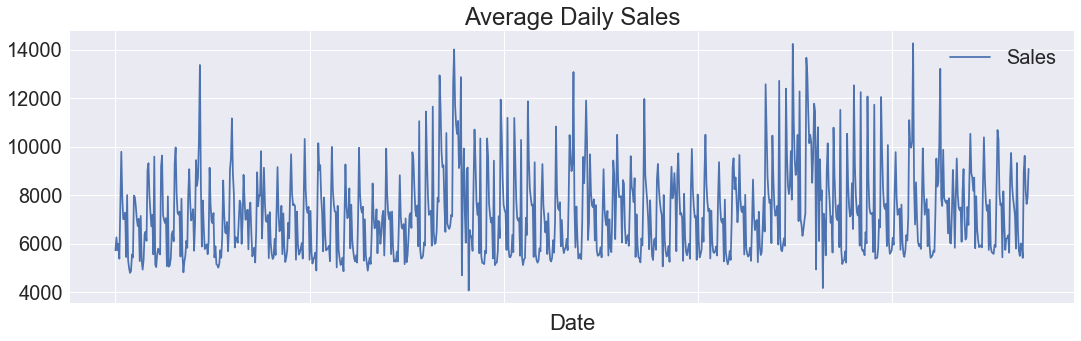

In [59]:
average_sales_per_day = df.groupby('Date')["Sales"].mean()
fig = plt.subplots(1,1, sharex=True, figsize=(18, 5))
average_sales_per_day.plot(legend=True, title="Average Daily Sales")

In [60]:
#Define the full data
X, y = np.array(df.loc[(df['Set'] == 1)][features_x]),np.array(df.loc[(df['Set'] == 1)][features_y])

In [61]:
#Flatten the full data
y=np.ravel(y)

In [62]:
# split into training and test for the purposes of the demonstration
# make feature matrix
test_size = 0.1
rstate = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            random_state=rstate)

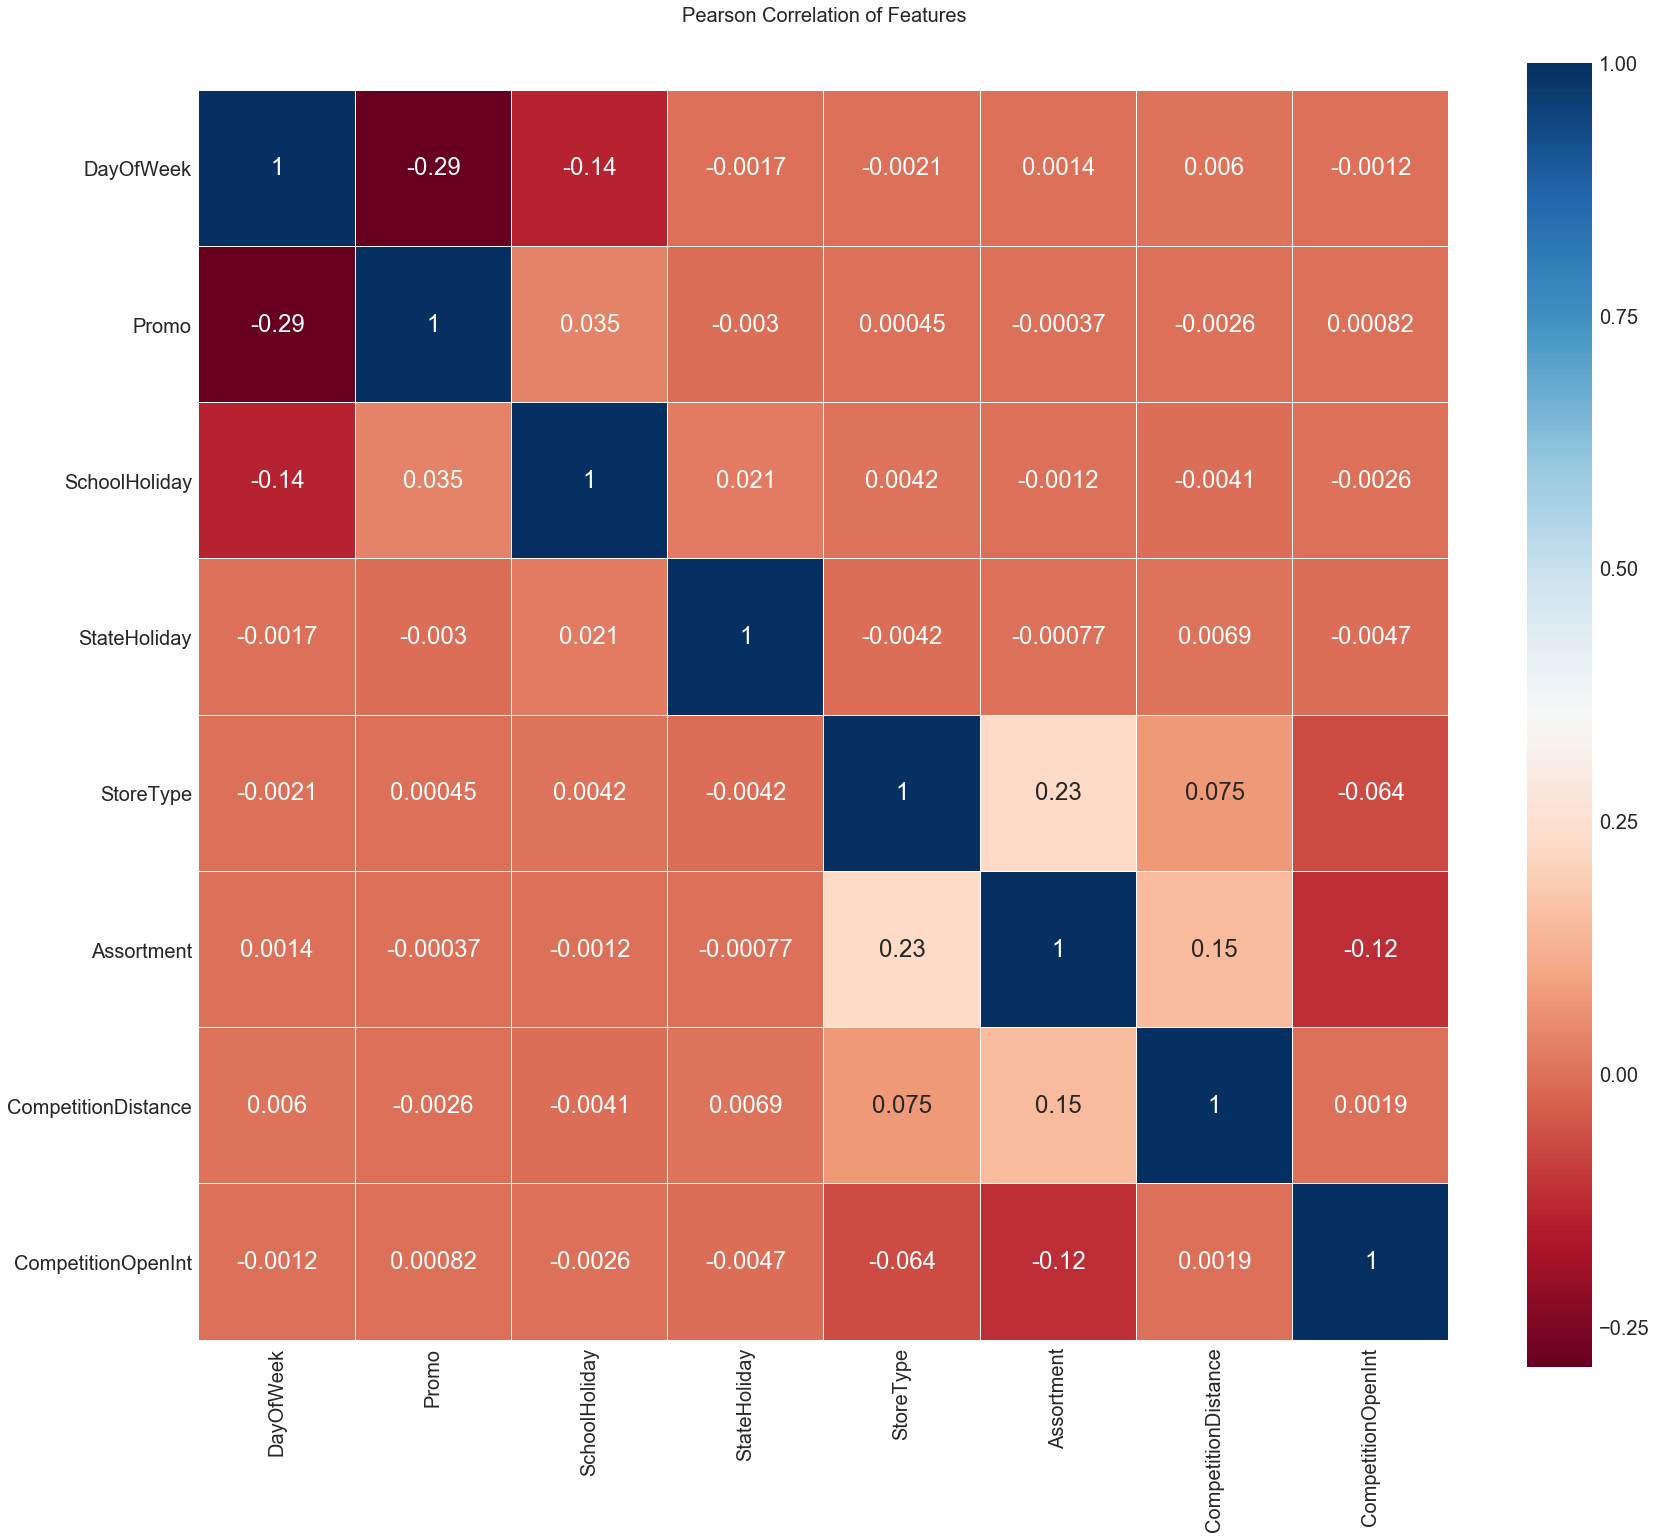

In [63]:
colormap = plt.cm.RdBu
sns.set(font_scale=2)
plt.figure(figsize=(28,24))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(df[features_x].astype(float).corr(),linewidths=0.01,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# We will try the random forest regression

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [65]:
#Check the best depth of the random forest
#scores = []
#for d in range(18,24):
#    model =  RandomForestRegressor(max_depth=d)
#    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean())
#plt.plot(range(18,24), scores)

In [66]:
#Train our model
randomForest = RandomForestRegressor(max_depth=24)
randomForest.verbose = True
randomForest.fit(X_test, y_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

In [67]:
#Define the test data
#X_test=np.array(df.loc[(df['Set'] == 0)][features_x])
#X_test.shape

In [68]:
# evaluate performance of the random forest models

def rmsle(actual, predicted):
    """
    Args:
        actual (1d-array) - array of actual values (float)
        predicted (1d-array) - array of predicted values (float)
    Returns:
        root mean square log error (float)
    """
    return np.sqrt(np.mean(np.power(np.log1p(actual)-np.log1p(predicted), 2)))

def plot_actual_pred(train_actual, train_pred, 
                     test_actual, test_pred,
                     target):
    """
    Args:
        train_actual (1d-array) - actual training values (float)
        train_pred (1d-array) - predicted training values (float)
        test_actual (1d-array) - actual test values (float)
        test_pred (1d-array) - predicted test values (float)
        target (str) - target property
    Returns:
        matplotlib scatter plot of actual vs predicted
    """
    s = 75
    lw = 0
    alpha = 0.2
    train_color = 'orange'
    train_marker = 's'
    test_color = 'red'
    test_marker = '^'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(train_pred, train_actual,
                     marker=train_marker, color=train_color, s=s, 
                     lw=lw, alpha=alpha, label='train')
    ax = plt.scatter(test_pred, test_actual,
                     marker=test_marker, color=test_color, s=s, 
                     lw=lw, alpha=alpha, label='test')
    ax = plt.legend(frameon=False, fontsize=fontsize, handletextpad=0.4)    
    all_vals = list(train_pred) + list(train_actual) + list(test_pred) + list(test_actual)
    full_range = abs(np.max(all_vals) - np.min(all_vals))
    cushion = 0.1
    xmin = np.min(all_vals) - cushion*full_range
    xmax = np.max(all_vals) + cushion*full_range
    ymin = xmin
    ymax = xmax    
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.plot([xmin, xmax], [ymin, ymax], 
                  lw=axis_width, color='black', ls='--', 
                  label='__nolegend__')
    ax = plt.xlabel('predicted ' + target, fontsize=fontsize)
    ax = plt.ylabel('actual ' + target, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax  
# plot the feature importances

def plot_importances(X_train, sorted_features, sorted_importances):
    """
    Args:
        X_train (nd-array) - feature matrix of shape (number samples, number features)
        sorted_features (list) - feature names (str)
        sorted_importances (list) - feature importances (float)
    Returns:
        matplotlib bar chart of sorted importances
    """
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'
    ax = plt.bar(range(X_train.shape[1]), sorted_importances,
                 color=bar_color, align=align, label=label)
    ax = plt.xticks(range(X_train.shape[1]), sorted_features, rotation=90)
    ax = plt.xlim([-1, X_train.shape[1]])
    ax = plt.ylabel('Average impurity decrease', fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

In [69]:
# report the most important featuers for predicting each target

# collect ranking of most "important" features for E
importances =  randomForest.feature_importances_
descending_indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in descending_indices]
sorted_features_x = [features_x[idx] for idx in descending_indices]
print('The most important feature for sales is %s' % sorted_features_x[0])

The most important feature for sales is CompetitionDistance


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


RMSLE for sales = 0.189 (training) and 0.154 (test)


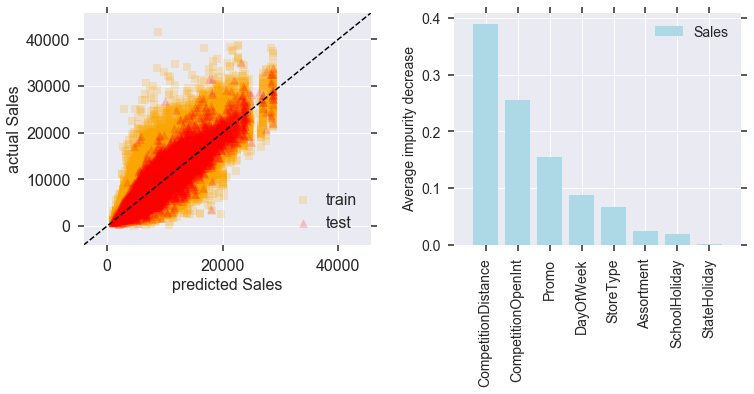

In [70]:
#Plot prediction results and importances
y_train_pred = randomForest.predict(X_train)
y_test_pred = randomForest.predict(X_test)
target = 'Sales'
print('RMSLE for sales = %.3f (training) and %.3f (test)' 
      % (rmsle(y_train, y_train_pred),  (rmsle(y_test, y_test_pred))))
fig = plt.figure(3, figsize=(11,6))
ax1 = plt.subplot(121)
ax1 = plot_actual_pred(y_train, y_train_pred,
                       y_test, y_test_pred,
                       target)
ax2 = plt.subplot(122)
ax2 = plot_importances(X_train, sorted_features_x, sorted_importances)
ax2 = plt.legend(['Sales'], fontsize=14, frameon=False)
plt.tight_layout()
plt.show()
plt.close()